# Householder triangularization

## Householder Reflections

The stable way to get a $QR$ factorization is to operate orthogonally (unitarily) in order to produce a triangular $R$. Similar to Gaussian elimination, we proceed one column at a time, zeroing entries below the sub-diagonal. Instead of elementary triangular row operations, though, we can choose from reflections or rotations.

$$
\begin{bmatrix} \times & \times & \times \\  \times & \times & \times \\  \times & \times & \times \\  \times & \times & \times \\  \times & \times & \times \\ \end{bmatrix} \stackrel{Q_1}{\to} \begin{bmatrix} \times & \times & \times \\  0 & \times & \times \\  0 & \times & \times \\  0 & \times & \times \\  0 & \times & \times \\ \end{bmatrix} \stackrel{Q_2}{\to} \begin{bmatrix} \times & \times & \times \\  0 & \times & \times \\  0 & 0 & \times \\  0 & 0 & \times \\  0 & 0 & \times \\ \end{bmatrix} \stackrel{Q_3}{\to} \begin{bmatrix} \times & \times & \times \\  0 & \times & \times \\  0 & 0 & \times \\  0 & 0 & 0 \\  0 & 0 & 0 \\ \end{bmatrix}
$$

The key step is to find, given $\mathbf{x}$, a unitary $F$ such that $F\mathbf{x}=\alpha \mathbf{e}_1$ for a scalar $\alpha$. Since $F$ preserves the 2-norm, $\alpha= \pm \|\mathbf{x}\|_2$. One can simply exhibit the solution. Define $\mathbf{v}=\alpha \mathbf{e}_1 - \mathbf{x}$ and set $$ F = I - 2 \frac{\mathbf{v}\mathbf{v}^*}{\mathbf{v}^*\mathbf{v}}.$$

Notice the similarity to the orthogonal projector.

![HHR](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Householder.svg/503px-Householder.svg.png)

In [1]:
m = 5;
I = eye(m);
x = randn(m);  alpha = norm(x);
v = alpha*[1;zeros(m-1)] - x;
F = I - 2*(v*v')/dot(v,v);
norm(F'*F-I)

6.274366372228879e-16

In [2]:
F*x

5-element Array{Float64,1}:
  2.28349    
  0.0        
 -5.55112e-17
  0.0        
  0.0        

In context, $\mathbf{x}$ is drawn from rows $j$ to $m$ of column $j$, so that $F$ (applied to the lower rows) puts zeros below the diagonal as desired. For example,

In [3]:
n = 3;
A = randn(m,n);  
x = A[:,1];  
v = [ x[1]+sign(x[1])*norm(x); x[2:end] ]; 
v = v/norm(v);
F = I - 2*(v*v');
F*A

5×3 Array{Float64,2}:
 -2.25396      -1.58784    -0.134974 
  1.71196e-16   0.948728   -0.569928 
  3.75608e-17  -0.0738045   0.0430322
 -3.20111e-17  -0.261579    0.961307 
 -6.93889e-18   0.558271    1.08048  

Once $j$ sweeps from 1 to $n$, the matrix will be transformed into the $R$. If we accumulate the actions of these reflectors, we end up with the $Q$ as well (the full one or the thin one, as we choose).  

There is an some important shortcut to know. In applications we rarely want the actual $Q$ or even the thin $\hat{Q}$; instead we want the capability of applying $Q$ or $Q^*$ to a given vector. It's more efficient to store the $\mathbf{v}$ vectors of the reflectors and apply them on demand, using 

$$F\mathbf{z} = \mathbf{z} - 2\frac{\mathbf{v}^*\mathbf{z}}{\mathbf{v}^*\mathbf{v}}v.$$

In Julia, the `qrfact` command returns the $R$ and the Householder vectors in a compact format. 

In [4]:
QR = qrfact(A)

Base.LinAlg.QRCompactWY{Float64,Array{Float64,2}}([-2.25396 -1.58784 -0.134974; -0.535659 -1.13385 0.169457; … ; -0.37069 -0.125603 0.555754; 0.0120276 0.268067 0.81829],[1.40147 1.24606 0.206231; 6.94734e-310 1.83673 -0.211877; 6.94734e-310 6.94734e-310 1.01089])

A better-known format is used by LAPACK, which can be called directly (overwriting the input matrix):

In [5]:
QR = copy(A);
Base.LinAlg.LAPACK.geqrf!(QR);
@show QR;

QR = [-2.25396 -1.58784 -0.134974; -0.535659 -1.13385 0.169457; -0.0508576 -0.035439 -1.5458; -0.37069 -0.125603 0.555754; 0.0120276 0.268067 0.81829]


The upper triangle is just $R$, while the lower triangle contains the Householder vectors with first element normalized to 1.

In [6]:
R = triu(QR); 
HH(v) = eye(length(v)) - 2*(v*v')./(v'*v);
v1 = [1;QR[2:m,1]];  F1 = HH(v1);
v2 = [1;QR[3:m,2]];  F2 = HH(v2);
v3 = [1;QR[4:m,3]];  F3 = HH(v3);

In [7]:
Q = F1*cat([1,2],eye(1),F2)*cat([1,2],eye(2),F3);  # block diagonal constructions
@show norm(Q*R-A);

norm(Q * R - A) = 5.770966355010983e-16


# Complexity of Orthogonal Triangularization

## Complexity of Householder's Algorithm

> ** THEOREM. ** Householder orthogonalization has the following asymptotic operation count is $\sim 2mn^2-\frac{2}{3} n^3$, i.e.: $$\lim_{m,n\to \infty} \frac{\# \text{flops}}{2mn^2-\frac{2}{3}n^3} = 1.$$

In particular, Householder's Algorithm requires significantly less flops to run than either the classical Gram-Schmidt or the modified Gram-Schmidt.

## Orthogonal Triangularization vs. Triangular Orthogonalization

The `qr` function in Julia (and Matlab and SciPy), in contrast, defaults to using a Householder QR algorithm.  This gives an orthogonal $Q$ matrix and an accurate $R$:

In [8]:
# Classical Gram–Schmidt (Trefethen algorithm 7.1), implemented in the simplest way
# (We could make it faster by unrolling loops to avoid temporaries arrays etc.)
function clgs(A)
    m,n = size(A)
    Q = similar(A)
    R = zeros(eltype(A),n,n)
    for j = 1:n
        aⱼ = A[:,j]
        vⱼ = copy(aⱼ) # use copy so that modifying vⱼ doesn't change aⱼ
        for i = 1:j-1
            qᵢ = Q[:,i]
            R[i,j] = dot(qᵢ, aⱼ)
            vⱼ -= R[i,j] * qᵢ
        end
        R[j,j] = norm(vⱼ)
        Q[:,j] = vⱼ / R[j,j]
    end
    return Q, R
end

# Modified Gram–Schmidt (Trefethen algorithm 8.1)
function mgs(A)
    m,n = size(A)
    Q = similar(A)
    R = zeros(eltype(A),n,n)
    for j = 1:n
        aⱼ = A[:,j]
        vⱼ = copy(aⱼ)
        for i = 1:j-1
            qᵢ = Q[:,i]
            R[i,j] = dot(qᵢ, vⱼ) # ⟵ NOTICE: mgs has vⱼ, clgs has aⱼ
            vⱼ -= R[i,j] * qᵢ
        end
        R[j,j] = norm(vⱼ)
        Q[:,j] = vⱼ / R[j,j]
    end
    return Q, R
end

mgs (generic function with 1 method)

In [9]:
(U,s,V) = svd(randn(80,80));
s = 2.0.^(-1:-1:-80);
A = U*diagm(s)*V';
(Qc,Rc) = clgs(A);  # classical
(Qm,Rm) = mgs(A); # modified
(Qh,Rh) = qr(A); # Householder

(
[-0.1891 0.17465 … 0.0313284 -0.0725869; 0.263572 -0.0759909 … -0.101085 -0.0149264; … ; -0.0281206 -0.088226 … -0.0229401 -0.024252; 0.108626 0.0728708 … -0.198116 0.0716586],

[-0.0423232 -0.0273643 … -0.017747 -0.0449594; 0.0 -0.0236431 … 0.0041207 -0.0553444; … ; 0.0 0.0 … 5.03546e-18 -3.3892e-18; 0.0 0.0 … 0.0 8.54912e-18])

In [10]:
using PyPlot
n = size(A,2)

80

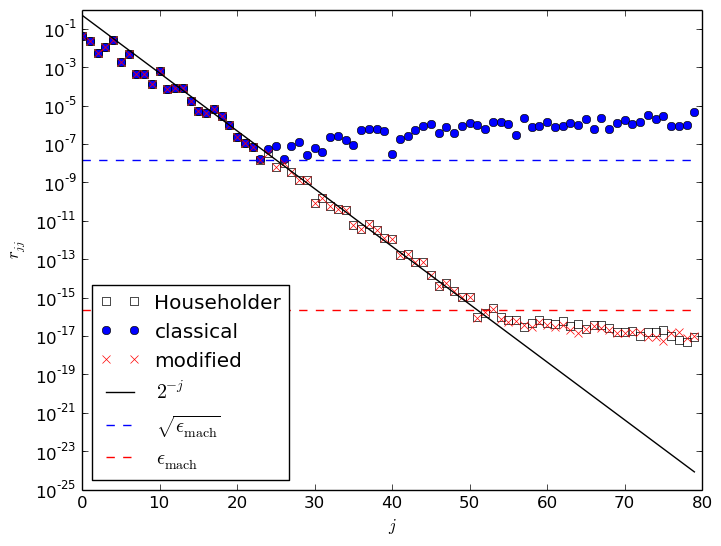

PyObject <matplotlib.text.Text object at 0x7fe36c648910>

  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /opt/julia_packages/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /opt/julia_packages/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /opt/julia_p

In [11]:
semilogy(abs(diag(Rh)), "s", mfc="none"); semilogy(diag(Rc), "bo"); semilogy(diag(Rm), "rx")
semilogy(2.0 .^ -(1:n), "k-"); semilogy(ones(n)*sqrt(eps()), "b--"); semilogy(ones(n)*eps(), "r--")
legend(["Householder","classical","modified",L"2^{-j}", L"\sqrt{\epsilon_\mathrm{mach}}", L"\epsilon_\mathrm{mach}"], loc="lower left")
ylabel(L"r_{jj}"); xlabel(L"j")

## A worked example

Consider the following matrix:

$$
A = \begin{bmatrix} 12 & -51 & 4\\ 6 & 167 & -68\\ -4 & 24 & -41 \end{bmatrix}
$$

We want to find the QR factorization via Householder reflectors.

First, we need to find a reflection that transforms the first column of matrix A, vector $\mathbf{a}_1 = (12, 6, -4)^T$, into $\|\mathbf{a}_1\| \;\mathrm{e}_1 = (14, 0, 0)^T.$

Now, 
$$\mathbf{u} = \mathbf{x} - \alpha\mathbf{e}_1,\quad \text{and}\quad \mathbf{v} = {\mathbf{u}\over\|\mathbf{u}\|}.$$

Here, $\alpha =14$ and $\mathbf{x} = \mathbf{a}_1 = (12, 6, -4)^T$

Therefore:
$$
\mathbf{u} = (-2, 6, -4)^T=({2})(-1, 3, -2)^T\quad \text{and}\quad \mathbf{v} = {1 \over \sqrt{14}}(-1, 3, -2)^T,
$$


\begin{align}
Q_1 &= I - {2 \over \sqrt{14} \sqrt{14}} \begin{pmatrix} -1 \\ 3 \\ -2 \end{pmatrix}\begin{pmatrix} -1 & 3 & -2 \end{pmatrix}\\
&=I - {1 \over 7}\begin{pmatrix}
1 & -3  & 2 \\
-3 & 9 & -6 \\
2  & -6  & 4
\end{pmatrix}\\
&= \begin{pmatrix}
6/7 & 3/7   &  -2/7 \\
3/7  &-2/7  &  6/7 \\
-2/7 & 6/7  &   3/7 \\
\end{pmatrix}.
\end{align}

Now observe:

$$
Q_{1}A=\begin{pmatrix}
14 & 21 & -14 \\
0 & -49 & -14 \\
0 & 168 & -77 \end{pmatrix},
$$

so we already have almost a triangular matrix. We only need to zero the $(3, 2)$ entry.

Take the $(1, 1)$ minor, and then apply the process again to

$$
A^\prime = M_{11} = \begin{pmatrix}
-49 & -14 \\
168 & -77 \end{pmatrix}.
$$

By the same method as above, we obtain the matrix of the Householder transformation

$$
Q_2 = \begin{pmatrix}
1 & 0 & 0 \\
0 & -7/25 & 24/25 \\
0 & 24/25 & 7/25 \end{pmatrix}
$$

after performing a direct sum with 1 to make sure the next step in the process works properly.

Now, we find

$$
Q=Q_1^T Q_2^T=\begin{pmatrix}
6/7 & -69/175 & 58/175 \\
3/7 & 158/175 & -6/175 \\
-2/7 & 6/35 & 33/35 \end{pmatrix}.
$$

$$
R=Q_2Q_1A=Q^T A=\begin{pmatrix}
14 & 21 & -14 \\
0 & 175 & -70 \\
0 & 0 & -35 \end{pmatrix}.
$$

The matrix $Q$ is orthogonal and $R$ is upper triangular, so $A = QR$ is the required QR-decomposition. 